## eCash vs Pass users ridership patterns

In [2]:
# loading libraries
import psycopg2
import pandas as pd
import numpy as np
import pandas.io.sql as psql

### Connecting to Redshhift

In [3]:
# connecting to redshift 
dbname1, host1, port1, user1, password1 = pd.read_csv("../../MTC/credentials.csv")
con = psycopg2.connect(dbname= dbname1, host= host1, port= port1, user= user1, password= password1)

In [4]:
# get a cursor from DB connection
cur = con.cursor()

In [5]:
# execute query and load into pandas df
data = psql.read_sql('SELECT * FROM "clipper"."rpt-cashpass3";', con)

### Cleaning Data

In [7]:
#data.sort_values(['applicationserialnumber','year', 'month'])

In [8]:
len(data)

14854169

In [9]:
#drop if no muni use (cash or pass) in the month
data.drop(data[(data.countpass == 0) & (data.countcash == 0)].index, inplace=True)

In [10]:
len(data)

10476386

### Analysis

In [11]:
#add total ride column
data = data.assign(totrides= data.countpass + data.countcash)

In [12]:
#add rides percentages
data = data.assign(passpercent= data.countpass / data.totrides)
data = data.assign(cashpercent= data.countcash / data.totrides)

In [13]:
#drop all records for clipper card if took less than 10 rides in a month
data2 = data.groupby('applicationserialnumber').filter(lambda x: x['totrides'].min()>10 )
data2.reset_index(drop=True, inplace=True) # reset index

In [14]:
len(data2)

1505712

These histograms look at the average rides per month for Muni users, not controlling for those who have switched between pass and cash. We want to control for just "switchers" because there are potentially confounding factors, ie a certain user type tends to use a pass and also tends to take a lot of rides. We want to keep all other factors constant. 

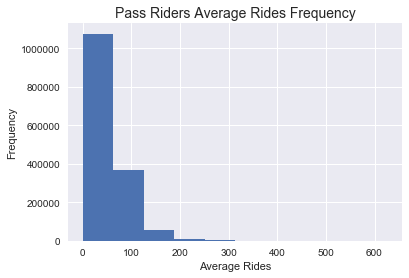

In [24]:
data2.countpass.plot.hist()
plt.title("Pass Riders Average Rides Frequency", fontsize=14)
plt.xlabel('Average Rides')
plt.show()

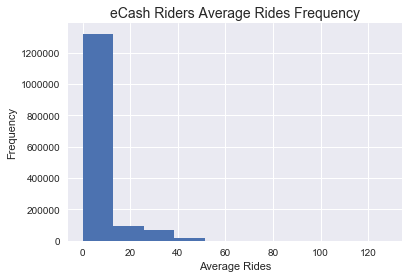

In [25]:
data2.countcash.plot.hist()
plt.title("eCash Riders Average Rides Frequency", fontsize=14)
plt.xlabel('Average Rides')
plt.show()

In [26]:
#find the total rides per user across the data
data2 = data2.assign(monthcount= 1) #add comlumn to count number of months 
data3 = data2.groupby('applicationserialnumber')[["countpass","countcash","totrides","monthcount"]].sum()
data3.reset_index(inplace=True) # reset index

In [28]:
#drop people who definitely didn't switch / wouldn't be helpful for this analysis
# bc they haven't taken more than 50 rides in either category acorss the two years
switchers = data3.drop(data3[(data3.countpass < 50) | (data3.countcash < 50)].index)

In [29]:
len(switchers)

6619

In [30]:
#drop people who only have cliper card data for less than 12 months
switchers2 = switchers.drop(switchers[(switchers.monthcount < 12)].index)

In [31]:
len(switchers2)

4967

In [32]:
#filter monthly transaction data for only the identified switchers
switchersdata = data2[data2['applicationserialnumber'].isin(list(switchers2.applicationserialnumber))]

In [33]:
#replace zero with NaN so that the mean doesn't include those months
switchersdata = switchersdata.replace(0, np.NaN)

In [34]:
#switchersdata.sort_values(['applicationserialnumber','year', 'month'])

In [35]:
#find the average rides per user per month
avgswitchers = switchersdata.groupby('applicationserialnumber')[["countpass","countcash","totrides","monthcount"]].mean()
avgswitchers.reset_index(inplace=True) # reset index

In [36]:
#find the total rides per user per month
avgswitchers = (switchersdata.groupby('applicationserialnumber')
.agg({'countpass':['mean','sum'], 'countcash':['mean','sum'],'totrides':['mean','sum'],'monthcount':'sum'})
.reset_index()
)

In [37]:
#rename columns
avgswitchers.columns = ["_".join(x) for x in avgswitchers.columns.ravel()]

In [38]:
#rename columns
avgswitchers = avgswitchers.rename(columns={'applicationserialnumber_':'applicationserialnumber', 'monthcount_sum':'totalmonths',
                             'countcash_mean':'avgcashpermonth', 'countcash_sum' : 'totalcashrides', 
                            'countpass_mean':'avgpasspermonth', 'countpass_sum' : 'totalpassrides',
                            'totrides_mean':'avgridespermonth', 'totrides_sum' : 'totalrides'})

In [39]:
#drop outlier
avgswitchers = avgswitchers.drop(avgswitchers[(avgswitchers.avgpasspermonth > 300)].index)

In [40]:
#add percentage of avg pass and cash per month
avgswitchers = avgswitchers.assign(avgpassridesperc= avgswitchers.totalpassrides / avgswitchers.totalrides)

avgswitchers = avgswitchers.assign(avgcashridesperc= avgswitchers.totalcashrides / avgswitchers.totalrides)

This scatter plot shows the average number of rides taken using eCash and pass per month by those who have switched. Each dot represents a user. The scale on the pass axis is much larger suggesting users who have used both pass and eCash take more rides when they have a pass. 

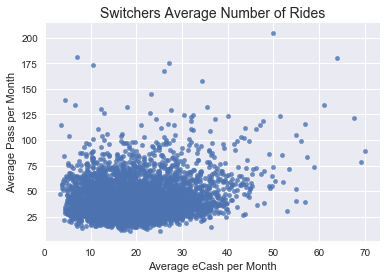

In [41]:
avgswitchers.plot.scatter(x = 'avgcashpermonth', y = 'avgpasspermonth', alpha = 0.8)
plt.title("Switchers Average Number of Rides", fontsize=14)
plt.xlabel('Average eCash per Month')
plt.ylabel('Average Pass per Month')
plt.show()

This histogram shows the total number of average rides per month switchers took when they used a pass.

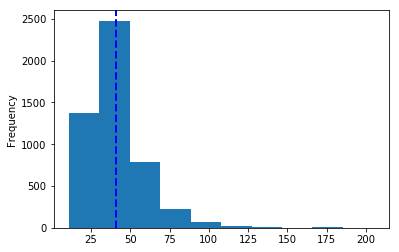

In [30]:
avgswitchers.avgpasspermonth.plot.hist().axvline(avgswitchers.avgpasspermonth.mean(), color='b', linestyle='dashed', linewidth=2)
plt.title("Switchers ", fontsize=14)
plt.xlabel('Pass Riders ')
plt.ylabel('Frequency')
plt.show()

In [31]:
#what is the average number of rides per a month that switchers took when they had a pass
avgswitchers.avgpasspermonth.mean()

40.962180825250606

This histogram shows the total number of average rides per month switchers took when they used a cash.

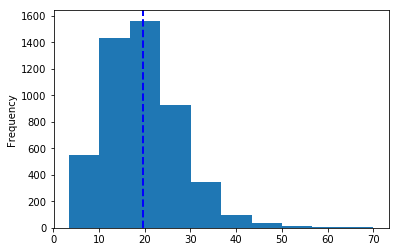

In [32]:
avgswitchers.avgcashpermonth.plot.hist().axvline(avgswitchers.avgcashpermonth.mean(), color='b', linestyle='dashed', linewidth=2)

In [33]:
#what is the average number of rides per a month that switchers took when they used eCash
avgswitchers.avgcashpermonth.mean()

19.510883302067914